In [47]:
from colour import Color
import eredivisie_nlp as enlp
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

### Load data

In [4]:
tweets = pd.read_pickle(f"{enlp.determine_root()}/data/raw/tweets_raw.pkl")
tweets = tweets[tweets.lang == 'nl'].reset_index(drop=True)
# The 'users' column contains a dictionary with 23 fields for each user.
# It's probably better to just expand this column into 23 ones with the prefix 'user_'
exp_tweets = pd.concat([tweets, tweets.user.apply(pd.Series).add_prefix("user_")], axis=1)
exp_tweets = exp_tweets.drop(columns = 'user')
# Remove the user__type column, as it has only one value for all items
exp_tweets.drop(['_type', 'user__type'], axis=1, inplace=True)
exp_tweets.shape

(172597, 49)

In [5]:
exp_tweets.columns

Index(['url', 'date', 'content', 'renderedContent', 'id', 'replyCount',
       'retweetCount', 'likeCount', 'quoteCount', 'conversationId', 'lang',
       'source', 'sourceUrl', 'sourceLabel', 'outlinks', 'tcooutlinks',
       'media', 'retweetedTweet', 'quotedTweet', 'inReplyToTweetId',
       'inReplyToUser', 'mentionedUsers', 'coordinates', 'place', 'hashtags',
       'cashtags', 'hashtag', 'user_username', 'user_id', 'user_displayname',
       'user_description', 'user_rawDescription', 'user_descriptionUrls',
       'user_verified', 'user_created', 'user_followersCount',
       'user_friendsCount', 'user_statusesCount', 'user_favouritesCount',
       'user_listedCount', 'user_mediaCount', 'user_location',
       'user_protected', 'user_linkUrl', 'user_linkTcourl',
       'user_profileImageUrl', 'user_profileBannerUrl', 'user_label',
       'user_url'],
      dtype='object')

# General statistics of type of tweets

In [6]:
print(f"Number of retweets: {len([rt for rt in exp_tweets['retweetedTweet'] if not np.isnan(rt)])}")
print(f"Number of replies: {len([rt for rt in exp_tweets['inReplyToTweetId'] if not np.isnan(rt)])}")
print(f"Number of tweets quoting another: {len([rt for rt in exp_tweets['quotedTweet'] if type(rt) == dict])}")
print(f"Number of tweets with coordinates: {len([rt for rt in exp_tweets['coordinates'] if type(rt) == dict])}")

Number of retweets: 0
Number of replies: 6502
Number of tweets quoting another: 5860
Number of tweets with coordinates: 10050


In [7]:
print(f"Overlap between replying and quoting tweets: {len([quote for quote, reply in zip(exp_tweets['quotedTweet'], exp_tweets['inReplyToTweetId']) if type(quote) == dict and type(reply) == dict])}")

Overlap between replying and quoting tweets: 0


# Plot temporal distribution of tweets
Done:
1. Basic boxplots showing distribution of # of tweets before, during, and after match

In [8]:
# load data files
df = pd.read_pickle(f"{enlp.determine_root()}/data/master_annotations.pkl")
grades = pd.read_csv(enlp.determine_root() + "/data/grades.csv", index_col=[0])

# lowercase GAE for Go Ahead Eagles
df['hashtag'] = df['hashtag'].str.lower()

# get set of hashtags to iterate over
hashtags = [tag for tag in list(set(df.hashtag)) if tag in list(set(grades.hashtag))]

# keep track of dataset size per fixture
num_tweets = []

for hashtag in tqdm(hashtags):
    # get playing times
    start_time = pd.to_datetime(grades[grades.hashtag == hashtag].datetime.tolist()[0])
    end_time = start_time + pd.DateOffset(hours=1, minutes=50)  # we assume 5 minutes extra time

    # slice the dataframe on the start and end timestamps
    before = df.loc[(df.hashtag == hashtag) & (df.date < start_time)]
    during = df.loc[(df.hashtag == hashtag) & (df.date > start_time) & (df.date < end_time)]
    after = df.loc[(df.hashtag == hashtag) & (df.date > end_time)]

    # add number of tweets information to list
    num_tweets.append([before.shape[0], during.shape[0], after.shape[0]])

100%|██████████| 204/204 [00:06<00:00, 30.15it/s]


In [9]:
temporal_dist = pd.DataFrame({
    'before': [t[0] for t in num_tweets],
    'during': [t[1] for t in num_tweets],
    'after': [t[2] for t in num_tweets]})

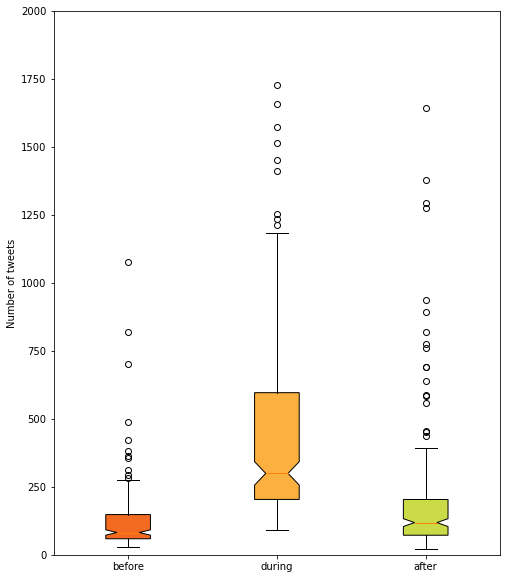

In [10]:
colors = ['#f26b21', '#fbb040', '#cbdb47']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[8,10])
bplot = ax.boxplot(temporal_dist, notch=True, labels=temporal_dist.columns, patch_artist=True)
ax.set_ylim([0,2000])
ax.set_ylabel('Number of tweets')
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
plt.savefig(enlp.determine_root() + "/res/figures/befduraft_box.png")
plt.show()

# Distribution of tweets per club
Done:
1. Split number of tweets based on which squad is playing
Ready:
1. This creates three categories of fixtures: both top teams, one top team, both bottom teams. We expect a strong linear connection between # of tweets and league positon/size of fanbase. The Eredivisie standings on February 21, 2022 were: aja, psv, fey, az, twe, vit, utr, nec, cam, gro, hee, her, rkc, gae, for, wil, pec, spa

In [11]:
ranking = ['aja', 'psv', 'fey', 'az', 'twe', 'vit', 'utr', 'nec', 'cam', 'gro', 'hee','her', 'rkc', 'gae', 'for', 'wil', 'pec', 'spa']
tweet_numbers = []
for club in ranking:
    num_tweets = []
    for num, tag in zip(temporal_dist.during, hashtags):
        if club in tag:
            num_tweets.append(num)
    while len(num_tweets) < 23:
        # ensure similar length of columns
        num_tweets.append(False)
    tweet_numbers.append(num_tweets)
club_dist = pd.DataFrame({c: num for c, num in zip(ranking, tweet_numbers)})
club_dist

,aja,psv,fey,az,twe,vit,utr,nec,cam,gro,hee,her,rkc,gae,for,wil,pec,spa
0,1176,575,747,248,282,292,1411,234,747,425,292,1176,98,111,836,1212,255,240
1,1212,519,685,289,374,519,363,278,689,229,575,98,234,248,1183,240,241,166
2,1411,910,689,333,267,1157,401,333,171,221,141,141,685,626,171,186,420,162
3,1157,760,626,241,389,289,158,425,159,391,278,111,321,229,217,247,384,158
4,1134,428,586,1134,401,255,186,240,240,284,217,153,223,420,282,222,586,715
5,836,3831,391,159,1452,166,634,374,384,169,272,191,363,910,254,443,219,195
6,1183,840,511,321,469,760,150,840,428,284,223,150,251,943,169,175,269,227
7,943,707,827,254,200,166,187,282,219,328,221,543,222,272,269,255,200,184
8,3831,535,715,284,256,827,403,323,153,227,389,239,300,284,162,268,282,226
9,1452,428,839,469,323,356,420,839,323,614,256,187,205,267,511,722,790,487


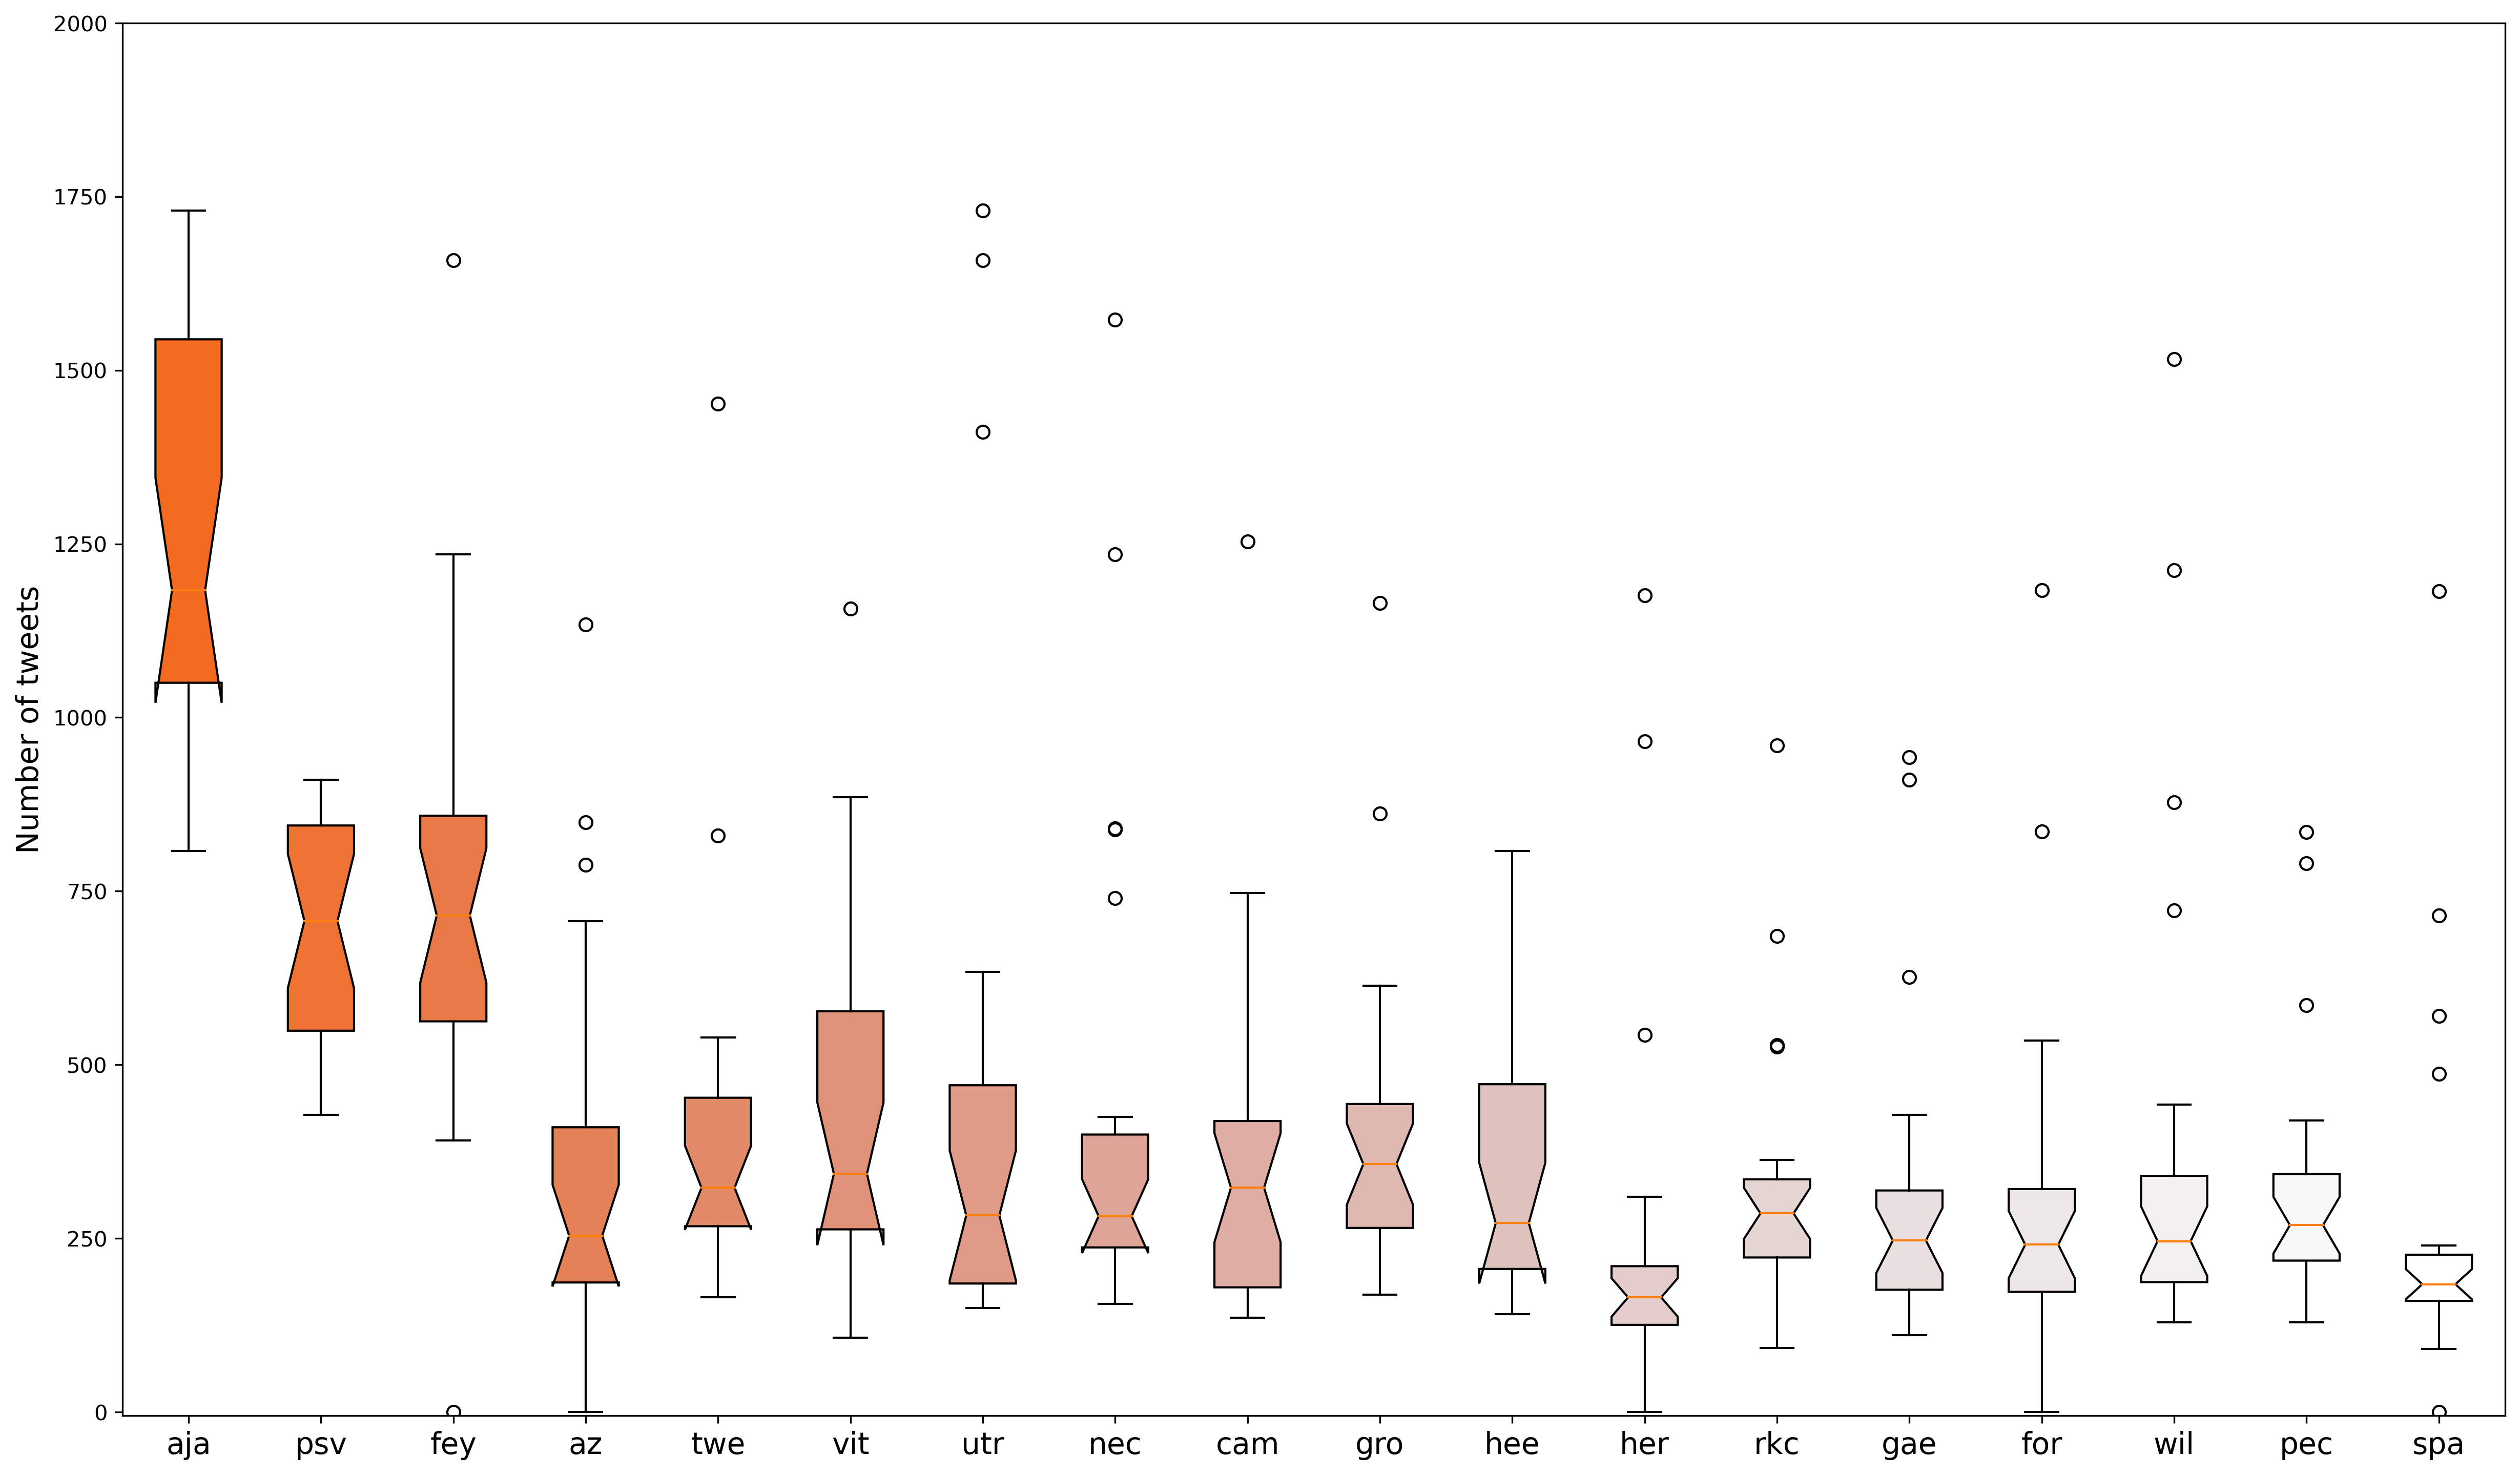

In [12]:
# set color range
orange = Color("#f26b21")
colors = list(orange.range_to(Color('white'), 18))
colors = [c.get_hex() for c in colors]


fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=[20,12], dpi=300)

bplot = ax1.boxplot(club_dist, notch=True, patch_artist=True)
ax1.set_ylim([-5,2000])
ax1.set_ylabel('Number of tweets', size=14)
ax1.set_xticklabels(club_dist.columns, size=14)
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
plt.savefig(enlp.determine_root() + "/res/figures/club_tweet_box.png")
plt.show()

In [13]:
temporal_dist['hashtag'] = [h[1:] for h in hashtags]
top_nine = ['aja', 'psv', 'fey', 'az', 'twe', 'vit', 'utr', 'nec', 'cam']
match_type = []
for h in hashtags:
    top = 0
    for tn in top_nine:
        if tn in h:
            top += 1
    match_type.append(top)
temporal_dist['top_9_teams'] = match_type
temporal_dist

,before,during,after,hashtag,top_9_teams
0,277,1176,282,ajaher,1
1,46,98,48,herrkc,0
2,166,1212,364,wilaja,1
3,162,747,192,feycam,2
4,63,292,149,heevit,1
...,...,...,...,...,...
199,148,1235,164,necfey,2
200,1078,4206,1275,feyaja,2
201,101,195,101,pechee,0
202,199,1658,450,utrfey,2


# Geographical map
For bragging rights, but also for testing biases

In [31]:
coords = [c for c in exp_tweets.coordinates if type(c) is dict]

In [58]:
map_hooray = folium.Map(location=[52.0907, 5.1214], zoom_start=9)
heat_data = [[coord['latitude'], coord['longitude']] for coord in coords]
HeatMap(heat_data, radius=15).add_to(map_hooray)
map_hooray